In [2]:
import matplotlib.pyplot as plt
import pymongo
from sshtunnel import SSHTunnelForwarder
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/home/miguel/.local/share/virtualenvs/scalable-simulations-8cB5xf1K/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
MONGO_HOST = 'TUD-tm2'
MONGO_DB ='distributed-simulation'
PKEY = '~/.ssh/id_rsa'
print("Trying to connect to mongoDB '{}'".format(MONGO_DB))
server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_pkey=PKEY,
    remote_bind_address=('127.0.0.1', 27017)
    )
server.start()
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client[MONGO_DB]


Trying to connect to mongoDB 'distributed-simulation'


In [4]:
# # 2 x 2 
global_ids = {}
global_ids['2x2'] = [793, 794, 795, 796, 797, 798, 799, 800, 801, 802]

distributed_ids = {}
distributed_ids['2x2'] = {}
distributed_ids['2x2']['DIALS F=100K'] = [1112, 1119, 1120, 1121, 1162, 1163, 1164, 1165, 1166, 1167]
distributed_ids['2x2']['DIALS F=4M'] = [805, 806, 807, 808, 809, 810, 811, 812, 813, 814]
distributed_ids['2x2']['DIALS F=1M'] = [774, 775, 776, 777, 778, 779, 780, 781, 782, 783]
distributed_ids['2x2']['DIALS F=500K'] = [764, 765, 766, 767, 768, 769, 770, 771, 772, 773]

untrained_ids = {}
untrained_ids['2x2'] = [784, 785, 786, 787, 788, 789, 790, 791, 792, 815]

# 5 x 5
global_ids['5x5'] = [889, 890, 891, 892, 893, 894, 895, 896, 897, 898]
distributed_ids['5x5'] = {}
distributed_ids['5x5']['DIALS F=100K'] = [902, 903, 904, 905, 906, 907, 908, 909, 910, 911]
distributed_ids['5x5']['DIALS F=500K'] = [882, 883, 884, 885, 886, 887, 888, 899, 900, 901]
distributed_ids['5x5']['DIALS F=1M'] = [849, 850, 851, 852, 853, 854, 855, 856, 857, 859]
distributed_ids['5x5']['DIALS F=4M'] = [858, 860, 861, 862, 863, 864, 865, 866, 867, 868]  

untrained_ids['5x5'] = [869, 870, 871, 872, 873, 874, 875, 876, 877, 878]
# 7 x 7
global_ids['7x7'] = [916, 917, 918, 919, 920, 921, 922, 923, 924, 952]

distributed_ids['7x7'] = {}
distributed_ids['7x7']['DIALS F=100K'] = [1150, 1151, 1152, 1153, 1156, 1157, 1158, 1159, 1160, 1161]
distributed_ids['7x7']['DIALS F=4M'] = [948, 949, 956, 957, 958, 959, 961, 962, 963, 1007]
distributed_ids['7x7']['DIALS F=1M'] = [938, 939, 940, 941, 942, 943, 944, 945, 946, 947]
distributed_ids['7x7']['DIALS F=500K'] = [935, 936, 937, 964, 966, 967, 968, 980, 981, 982]

untrained_ids['7x7'] = [983, 984, 986, 987, 989, 990, 991, 992, 993, 994]

# 10 x 10

global_ids['10x10'] = [1008, 1009, 1010, 1011, 1012]

distributed_ids['10x10'] = {}
distributed_ids['10x10']['DIALS F=4M'] = [1035, 1036, 1037, 1039]

untrained_ids['10x10'] = [1040, 1041, 1042, 1044]

global_means = {}
global_stds = {}
for env in global_ids.keys():
    global_means[env] = []
    global_stds[env] = []
    global_values = []
    for id in global_ids[env]:
        values = db.get_collection("metrics").find_one({'run_id': id, 'name': 'mean episodic return'})['values']
        if len(values) < 9:
            print(len(values))
            for _ in range(5-len(values)):
                values.append(values[-1])
        elif len(values) < 41:
            for _ in range(41-len(values)):
                values.append(values[-1])
        global_values.append(values)
    global_means[env].append(np.mean(global_values, axis=0))
    global_stds[env].append(np.std(global_values, axis=0)/np.sqrt(10))



untrained_means = {}
untrained_stds = {}
untrained_values = []

for env in untrained_ids.keys():
    untrained_means[env] = []
    untrained_stds[env] = []
    untrained_values = []
    for id in untrained_ids[env]:   
        values = db.get_collection("metrics").find_one({'run_id': id, 'name': 'mean episodic return'})['values']
        untrained_values.append(values)
    untrained_means[env].append(np.mean(untrained_values, axis=0))
    # print(np.array(untrained_values)[:,-1])
    untrained_stds[env].append(np.std(untrained_values, axis=0)/np.sqrt(len(untrained_values)))

distributed_means = {}
distributed_stds = {}

for env in distributed_ids.keys():
    distributed_means[env] = {}
    distributed_stds[env] = {}
    for key, ids in distributed_ids[env].items():
        distributed_means[env][key] = []
        distributed_stds[env][key] = []
        distributed_values = []
        for id in ids:
            distributed_values.append(db.get_collection("metrics").find_one({'run_id': id, 'name': 'mean episodic return'})['values'])
        distributed_means[env][key].append(np.mean(distributed_values, axis=0))
        distributed_stds[env][key].append(np.std(distributed_values, axis=0)/np.sqrt(len(distributed_values)))


influence_means = {}
influence_stds = {}
influence_values = []

for env in distributed_ids.keys():
    influence_means[env] = {}
    influence_stds[env] = {}
    for key, ids in distributed_ids[env].items():
        influence_means[env][key] = []
        influence_stds[env][key] = []
        influence_values = []
        for id in ids:
            influence_values.append(db.get_collection("metrics").find_one({'run_id': id, 'name': 'influence loss'})['values'])
        influence_means[env][key].append(np.mean(influence_values, axis=0))
        influence_stds[env][key].append(np.std(influence_values, axis=0)/np.sqrt(len(influence_values)))

global_agent_train_time = {}
distributed_agent_train_time = {}
distributed_influence_train_time = {}

global_agent_train_time['2x2'] = 1335.46
distributed_agent_train_time['2x2'] = 192.04
distributed_influence_train_time['2x2'] = 118.66

global_agent_train_time['5x5'] = 8733.8
distributed_agent_train_time['5x5'] = 230.23
distributed_influence_train_time['5x5'] = 640.07

global_agent_train_time['7x7'] = 18736.6
distributed_agent_train_time['7x7'] = 287.42
distributed_influence_train_time['7x7'] = 1367.52

global_agent_train_time['10x10'] = 42161.4
distributed_agent_train_time['10x10'] = 499.657
distributed_influence_train_time['10x10'] = 4090.42


global_time = {}
distributed_time = {}

untrained_time = {}
for env in global_agent_train_time.keys():
    global_time[env] = global_agent_train_time[env]*40/3600
    distributed_time[env] = (distributed_agent_train_time[env]*40 + distributed_influence_train_time[env])/3600
    untrained_time[env] = distributed_agent_train_time[env]*40/3600

5
5
5
4
5


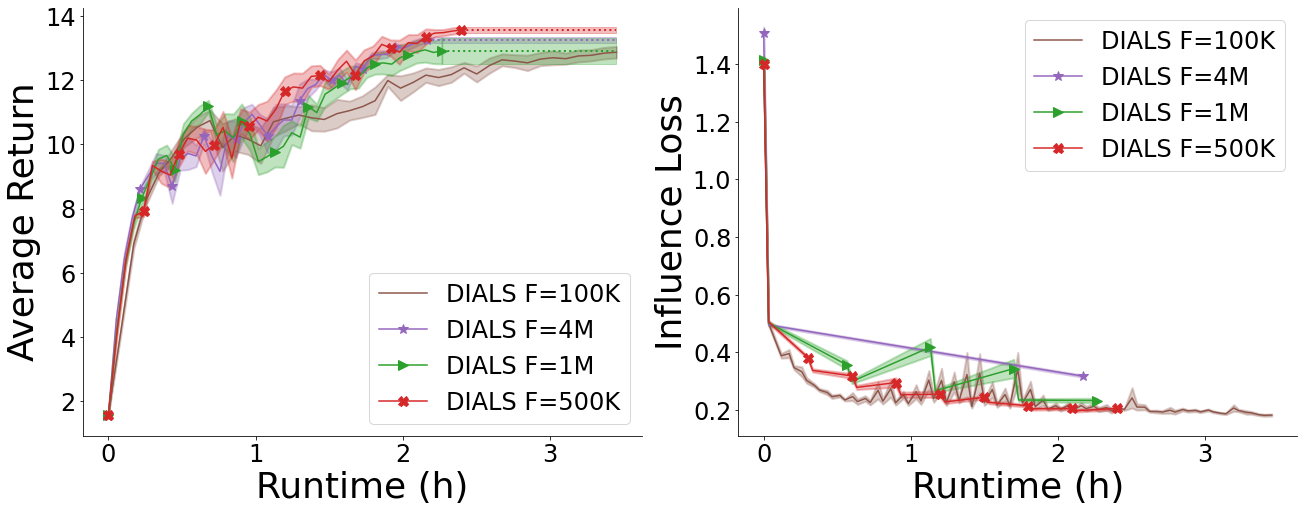

In [11]:
fig, ax = plt.subplots(1,2, figsize=(18,7), constrained_layout=True)
# plt.subplots_adjust(left=0.05, bottom=0.05, right=None, top=0.94, wspace=None, hspace=0.3)

env = '2x2'
# env = '5x5'
# env = '7x7'

distributed_time_100 = {}
distributed_time_100['2x2'] = (distributed_agent_train_time['2x2']*40 + distributed_influence_train_time['2x2']*40)/3600
distributed_time_100['5x5'] = (distributed_agent_train_time['5x5']*40 + distributed_influence_train_time['5x5']*40)/3600
distributed_time_100['7x7'] = (distributed_agent_train_time['7x7']*40 + distributed_influence_train_time['7x7']*40)/3600

total_times = {}
colors = {'DIALS F=100K': 'C5', 'DIALS F=500K': 'C3', 'DIALS F=1M': 'C2', 'DIALS F=4M': 'C4'}
markers = {'DIALS F=100K': '', 'DIALS F=500K': 'X', 'DIALS F=1M': '>', 'DIALS F=4M': '*'}

for key in distributed_means[env].keys():
    distributed_mean = distributed_means[env][key][0]
    distributed_std = distributed_stds[env][key][0]
    influence_mean = influence_means[env][key][0]
    total_time = (distributed_influence_train_time[env]*(len(influence_mean)//2-1) + distributed_agent_train_time[env]*(len(distributed_mean)-1))/3600
    total_times[key] = total_time
    color = colors[key]
    times = np.linspace(0, total_time, len(distributed_mean))
    ax[0].plot(times, distributed_mean, color=color, label=key, marker=markers[key], markevery=4, markersize=10)
    ax[0].fill_between(times, distributed_mean-distributed_std, distributed_mean+distributed_std, alpha=0.3, color=color, linewidth=2)

    times = np.linspace(total_time, distributed_time_100[env], 2)
    values = np.array([distributed_mean[-1], distributed_mean[-1]])
    std = np.array([distributed_std[-1], distributed_std[-1]])
    ax[0].plot(times, values, color=color, linestyle='dotted', linewidth=2)
    ax[0].fill_between(times, values-std, values+std, alpha=0.3, color=color)

# ax[0].set_xlim(-0.05, total_time+0.05)
# 2x2
# ax[0].set_ylim(142, 220)
# 5x5
# ax[0].set_ylim(150, 220)
# 7x7
# ax[0].set_ylim(150, 218)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


# CROSSENTROPY LOSS
for key in influence_means[env].keys():
    influence_mean = influence_means[env][key][0]
    influence_std = influence_stds[env][key][0]
    color = colors[key]
    total_time = distributed_agent_train_time[env]*(len(distributed_mean)-1)/3600
    times1 = np.linspace(0, total_time, len(influence_mean)//2)
    times2 = np.arange(0, len(influence_mean)//2)*distributed_influence_train_time[env]/3600
    times3 = np.arange(1, len(influence_mean)//2+1)*distributed_influence_train_time[env]/3600     
    times = np.hstack(zip(times1 + times2, times1 + times3))
    # times = np.linspace(0, total_time, len(influence_mean))
    ax[1].plot(times[:-1], influence_mean[:-1], color=color, label=key, marker=markers[key], markevery=2, markersize=10)
    ax[1].fill_between(times[:-1], influence_mean[:-1]-influence_std[:-1], influence_mean[:-1]+influence_std[:-1], alpha=0.3, color=color, linewidth=2)
# ax[1].set_xlim(-0.05, times[-1]+0.05)
# 2x2
# ax[1].set_ylim(0.27, 0.72)
# 5x5
# ax[1].set_ylim(0.25, 0.72)
# 7x7
# ax[1].set_ylim(0.23, 0.72)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)


handles, labels = ax[0].get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
# fig.legend(handles, labels, bbox_to_anchor = [0.73, 1], ncol=4, fontsize=18, markerscale=2)
ax[0].legend(handles, labels, loc=4, ncol=1, fontsize=24, markerscale=1) #bbox_to_anchor = [0.65, 1]
ax[1].legend(handles, labels, loc=1, ncol=1, fontsize=24, markerscale=1)
# plt.subplots_adjust(wspace=0, hspace=[0, 0, 0.3])
ax[0].set_ylabel('Average Return', fontsize=36)
ax[0].set_xlabel('Runtime (h)', fontsize=36)
ax[1].set_ylabel('Influence Loss', fontsize=36)
ax[1].set_xlabel('Runtime (h)', fontsize=36)
ax[0].tick_params(labelsize=24)
ax[1].tick_params(labelsize=24)
# ax[0].tick_params(labelsize=12)
# plt.savefig('DIALS_comparison_5x5.pdf')
# plt.savefig('DIALS_comparison_2x2.pdf')



# plt.savefig('DIALS_comparison_warehouse_7x7.pdf')
# plt.savefig('DIALS_comparison_warehouse_5x5.pdf')
plt.savefig('DIALS_comparison_warehouse_2x2.pdf')



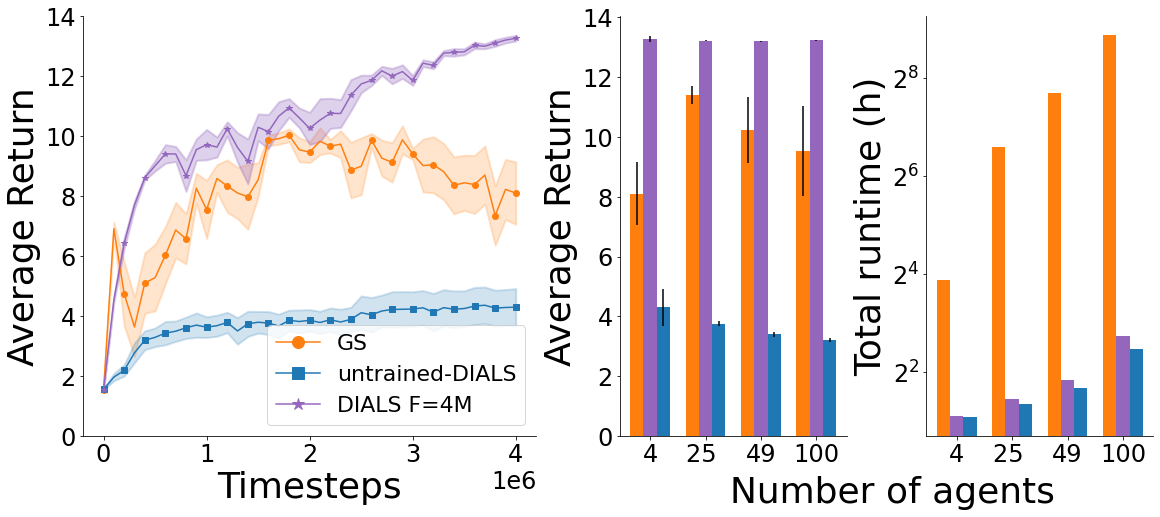

In [8]:
fig, ax = plt.subplots(1,3, figsize=(16,7), gridspec_kw={'width_ratios': [0.5, 0.25, 0.25]}, constrained_layout = True)

env = '2x2'
# env = '5x5'
# env = '7x7'

# GLOBAL
global_mean = global_means[env][0]
global_std = global_stds[env][0]
global_total_time = global_agent_train_time[env]*(len(global_mean) - 1)/3600
# times = np.linspace(0, global_total_time, len(global_mean))
times = np.linspace(0, 4.0e+6, len(global_mean))
ax[0].plot(times, global_mean, color='C1', label='GS', marker='o', markevery=2)
ax[0].fill_between(times, global_mean-global_std, global_mean+global_std, alpha=0.2, color='C1', linewidth=2)
# UNTRAINED
untrained_mean = untrained_means[env][0]
untrained_std = untrained_stds[env][0]
untrained_total_time = distributed_agent_train_time[env]*(len(untrained_mean) - 1)/3600
# times = np.linspace(0, untrained_total_time, len(untrained_mean))
times = np.linspace(0, 4.0e+6, len(untrained_mean))
ax[0].plot(times, untrained_mean, color='C0', label='untrained-DIALS', marker='s', markevery=2)
ax[0].fill_between(times, untrained_mean-untrained_std, untrained_mean+untrained_std, alpha=0.2, color='C0', linewidth=2)

# times = np.linspace(untrained_total_time, global_total_time, 2)

# values = np.array([untrained_mean[-1], untrained_mean[-1]])
# std = np.array([untrained_std[-1], untrained_std[-1]])
# ax[0].plot(times, values, color='C0', linestyle='dotted', linewidth=2)
# ax[0].fill_between(times, values-std, values+std, alpha=0.3, color='C0')


for key in ['DIALS F=4M']:
    distributed_mean = distributed_means[env][key][0]
    distributed_std = distributed_stds[env][key][0]
    influence_mean = influence_means[env][key][0]
    total_time = (distributed_influence_train_time[env]*len(influence_mean)//2-1)/3600 + (distributed_agent_train_time[env]*(len(distributed_mean)-1))/3600
    color = colors[key]
    times = np.linspace(0, 4.0e+6, len(distributed_mean))
    ax[0].plot(times, distributed_mean, color=color, label=key, marker=markers[key], markevery=2)
    ax[0].fill_between(times, distributed_mean-distributed_std, distributed_mean+distributed_std, alpha=0.3, color=color, linewidth=2)

    # times = np.linspace(total_time, global_total_time, 2)
    # values = np.array([distributed_mean[-1], distributed_mean[-1]])
    # std = np.array([distributed_std[-1], distributed_std[-1]])
    # ax[0].plot(times, values, color=color, linestyle='dotted', linewidth=2)
    # ax[0].fill_between(times, values-std, values+std, alpha=0.3, color=color)

# ax[0].set_xlim(-0.05, global_total_time+0.05)
ax[0].set_ylim(0, 14)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# fig.legend(handles, labels, bbox_to_anchor = [0.73, 1], ncol=4, fontsize=18, markerscale=2)
ax[0].legend(loc=4, ncol=1, fontsize=22, markerscale=2) #bbox_to_anchor = [0.65, 1]

# plt.subplots_adjust(wspace=0, hspace=[0, 0, 0.3])
ax[0].set_ylabel('Average Return', fontsize=36)
ax[0].set_xlabel('Timesteps', fontsize=36)
ax[0].tick_params(labelsize=24)
t = ax[0].xaxis.get_offset_text()
t.set_size(24)

# ax.set_xscale('log', base=2)
# ax[0].tick_params(labelsize=12)

# plt.subplots_adjust(left=0.05, bottom=0.05, right=None, top=0.94, wspace=None, hspace=0.3)

labels = ['4', '25 ', '49', '100']
x = np.arange(len(labels))*2.5
width = 0.6
global_means_list = [global_means['2x2'][0][-1], global_means['5x5'][0][-1], global_means['7x7'][0][-1], global_means['10x10'][0][-1]]
global_stds_list = [global_stds['2x2'][0][-1], global_stds['5x5'][0][-1], global_stds['7x7'][0][-1], global_stds['10x10'][0][-1]]
barh = ax[1].bar(x-width, global_means_list, yerr=global_stds_list, width=width, color='C1')
DIALS_means = [distributed_means['2x2']['DIALS F=4M'][0][-1], distributed_means['5x5']['DIALS F=4M'][0][-1], distributed_means['7x7']['DIALS F=4M'][0][-1], distributed_means['10x10']['DIALS F=4M'][0][-1]]
DIALS_stds = [distributed_stds['2x2']['DIALS F=4M'][0][-1], distributed_stds['5x5']['DIALS F=4M'][0][-1], distributed_stds['7x7']['DIALS F=4M'][0][-1], distributed_stds['10x10']['DIALS F=4M'][0][-1]]
barh = ax[1].bar(x, DIALS_means, yerr=DIALS_stds, width=width, color='C4')
untrained_means_list = [untrained_means['2x2'][0][-1], untrained_means['5x5'][0][-1], untrained_means['7x7'][0][-1], untrained_means['10x10'][0][-1]]
untrained_stds_list = [untrained_stds['2x2'][0][-1], untrained_stds['5x5'][0][-1], untrained_stds['7x7'][0][-1], untrained_stds['10x10'][0][-1]]
barh = ax[1].bar(x+width, untrained_means_list, yerr=untrained_stds_list, width=width, color='C0')
# barh = ax[1].barh([0,1,2],[6.16, 2.33, 2.13], height=0.5, color=['C1', 'C3', 'C0'])
ax[1].set_ylabel('Average Return', fontsize=36)
# ax[1].set_xlabel('Number of Agents', fontsize=36)
# ax[1].set_ylim(150, 220)

# ax[1].axes.get_xaxis().set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xticks(x, labels, fontsize=24)
ax[1].tick_params(labelsize=24)

barh = ax[2].bar(x-width, [global_time['2x2'], global_time['5x5'], global_time['7x7'], global_time['10x10']], width, color='C1')
barh = ax[2].bar(x, [distributed_time['2x2'], distributed_time['5x5'], distributed_time['7x7'], distributed_time['10x10']], width, color='C4')
barh = ax[2].bar(x+width, [untrained_time['2x2'], untrained_time['5x5'], untrained_time['7x7'], untrained_time['10x10']], width, color='C0')
# barh = ax[1].barh([0,1,2],[6.16, 2.33, 2.13], height=0.5, color=['C1', 'C3', 'C0'])
# ax[2].set_xlabel('Number of Agents', fontsize=36)
ax[2].set_ylabel('Total runtime (h)', fontsize=36)



# ax[1].axes.get_xaxis().set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_xticks(x, labels, fontsize=24)
ax[2].tick_params(labelsize=24)
ax[2].set_yscale('log', base=2)
# ax[1].spines['bottom'].set_visible(False)
# ax[1].set_xlim(0, 6.4)
# ax[1].bar_label(barh, labels=['GS', 'DIALS', 'DIALS untrained'], fontsize=18, padding=3)
# plt.legend(['GS', 'DIALS', 'untrained-DIALS'], loc=2, fontsize=24)
fig.text(0.63, 0.03, 'Number of agents', va='center', fontsize=36)
plt.savefig('warehouse_plot.pdf')


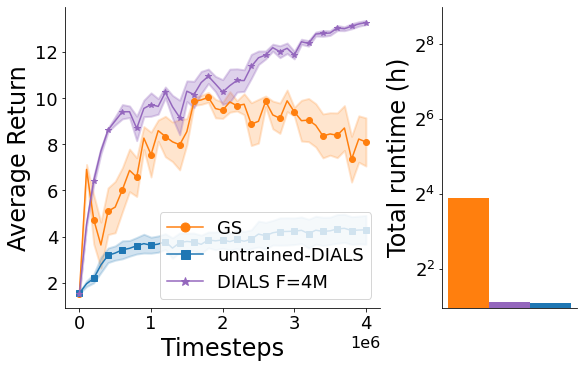

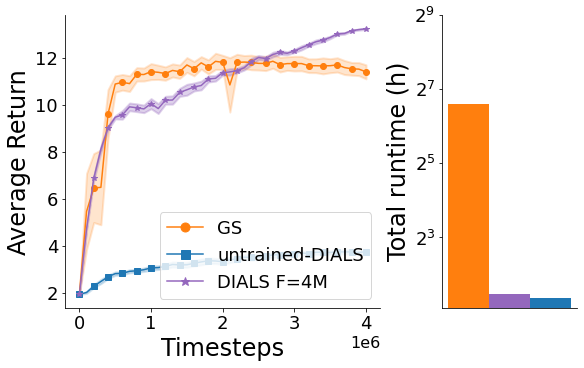

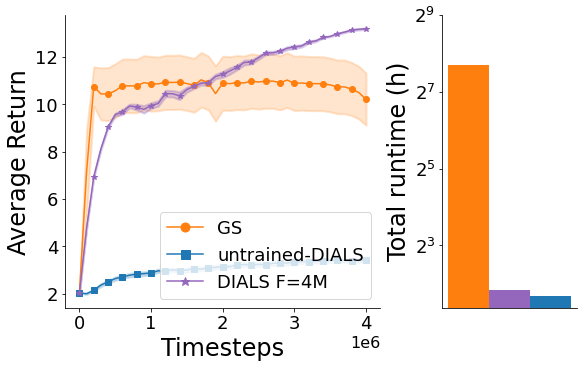

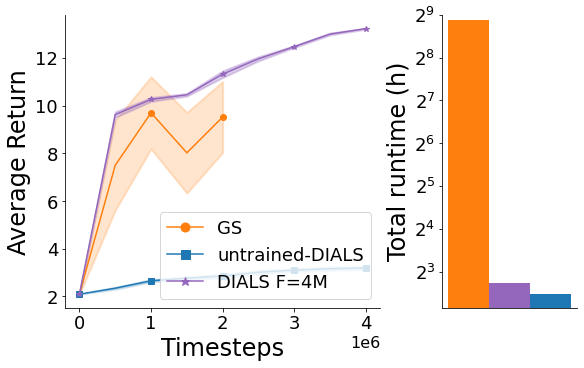

In [29]:
envs = ['2x2', '5x5', '7x7', '10x10']
titles = ['(a) 2 agents', '(b) 2 agents', '(c) 2 agents', '(d) 2 agents']
for i, env in enumerate(envs):

    fig, ax = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [0.7, 0.3]}, constrained_layout = True)
    # GLOBAL
    j = 0
    global_mean = global_means[env][0]
    global_std = global_stds[env][0]
    global_total_time = global_agent_train_time[env]*(len(global_mean) - 1)/3600
    # times = np.linspace(0, global_total_time, len(global_mean))
    times = np.linspace(0, 4.0e+6, len(global_mean))
    if env == '10x10':
        times = np.linspace(0, 2.0e+6, len(global_mean))
    ax[j].plot(times, global_mean, color='C1', label='GS', marker='o', markevery=2)
    ax[j].fill_between(times, global_mean-global_std, global_mean+global_std, alpha=0.2, color='C1', linewidth=2)
    # UNTRAINED
    untrained_mean = untrained_means[env][0]
    untrained_std = untrained_stds[env][0]
    untrained_total_time = distributed_agent_train_time[env]*(len(untrained_mean) - 1)/3600
    # times = np.linspace(0, untrained_total_time, len(untrained_mean))
    times = np.linspace(0, 4.0e+6, len(untrained_mean))
    
    ax[j].plot(times, untrained_mean, color='C0', label='untrained-DIALS', marker='s', markevery=2)
    ax[j].fill_between(times, untrained_mean-untrained_std, untrained_mean+untrained_std, alpha=0.2, color='C0', linewidth=2)

# times = np.linspace(untrained_total_time, global_total_time, 2)

# values = np.array([untrained_mean[-1], untrained_mean[-1]])
# std = np.array([untrained_std[-1], untrained_std[-1]])
# ax[0].plot(times, values, color='C0', linestyle='dotted', linewidth=2)
# ax[0].fill_between(times, values-std, values+std, alpha=0.3, color='C0')


    for key in ['DIALS F=4M']:
        distributed_mean = distributed_means[env][key][0]
        distributed_std = distributed_stds[env][key][0]
        influence_mean = influence_means[env][key][0]
        total_time = (distributed_influence_train_time[env]*len(influence_mean)//2-1)/3600 + (distributed_agent_train_time[env]*(len(distributed_mean)-1))/3600
        color = colors[key]
        times = np.linspace(0, 4.0e+6, len(distributed_mean))
        ax[j].plot(times, distributed_mean, color=color, label=key, marker=markers[key], markevery=2)
        ax[j].fill_between(times, distributed_mean-distributed_std, distributed_mean+distributed_std, alpha=0.3, color=color, linewidth=2)


    barh = ax[j+1].bar(-width, global_time[env], width, color='C1')
    barh = ax[j+1].bar(0, distributed_time[env], width, color='C4')
    barh = ax[j+1].bar(width, untrained_time[env], width, color='C0')
    # barh = ax[1].barh([0,1,2],[6.16, 2.33, 2.13], height=0.5, color=['C1', 'C3', 'C0'])
    # ax[2].set_xlabel('Number of Agents', fontsize=36)
    ax[j+1].set_ylabel('Total runtime (h)', fontsize=24)
    ax[j+1].set_yscale('log', base=2)
    ax[j+1].set_ylim(-2, 2**9)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].tick_params(labelsize=18)
    t = ax[j].xaxis.get_offset_text()
    t.set_size(16)

    ax[j].set_ylabel('Average Return', fontsize=24)
    ax[j].set_xlabel('Timesteps', fontsize=24)
    ax[j+1].spines['right'].set_visible(False)
    ax[j+1].spines['top'].set_visible(False)
    ax[j+1].tick_params(labelsize=18)
    ax[j+1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # ax[j].set_title(titles[i], loc='right', fontsize=24)

    handles, labels = ax[j].get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    ax[j].legend(handles, labels, loc=4, ncol=1, fontsize=18, markerscale=1.5)
    file = 'warehouse_curves_appendix' + str(i) + '.pdf'
    plt.savefig(file)